In [26]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import WMAP9 as cosmo
from scipy.integrate import quad
#from astropy.cosmology import Planck15   # You can choose a different cosmology if needed
import astropy.units as u
from astropy import constants as const
from astropy.cosmology import FlatLambdaCDM
from numba import jit

In [27]:

def lx_func(func, fixed_value):
    def f(x):
        return func(fixed_value, x)
    return f

def z_func(func, fixed_value):
    def f(x):
        
        return func(x,fixed_value)
    return f

In [28]:

def simpsons_integration(func, a, b, n=5000):
    h = (b - a) / n
    s = func(a) + func(b)

    for i in range(1, n, 2):
        s += 4 * func(a + i * h)
    for i in range(2, n, 2):
        s += 2 * func(a + i * h)

    return s * h / 3

In [29]:
import pandas as pd
from tabulate import tabulate

def Psi_Ueda(Lx):
     return 1/np.log(10)*1/Lx*((Lx/L_star)**(gamma1)+(Lx/L_star)**(gamma2))**(-1) 



def Psi_Ajello(Lx):
    return 1/Lx*(Lx/L_star)**(1-gamma2) #Function from Ajello et al 


def z_star(Lx): #Calc Z_star used for caculation of XLF for RG
    if (Lx <= L_c):
        return z_c *(Lx/L_c)**alpha
    else:
        return z_c
def z_star_2(Lx): #Calc Z_star used for caculation of XLF for RG
    if (Lx <= L_c_2):
        return z_c_2 *(Lx/L_c_2)**alpha_2
    else:
        return z_c_2

def e_z(z,Lx): #Used in calculation of XLF for RG. redshift evolution is of type PDF
    z_s =z_star(Lx)
    if z<=z_s:
        return (1+z)**(v_1)
    else: 
        return e_z(z_s,Lx) *((1+z)/(1+z_s))**(v_2)

def e_z_PL(z): #Used in calculation of XLF for Blazars, BLlac, and FSRQ. redshift evolution is of type PLF
    
    return (1+z)**(v_1 + v_2*z)

def v_s_1_func(lx):
    
    return v_1 + beta*(np.log10(lx*1.0)-44)

def e_z_all(z,Lx): #Used in calculation of XLF for AGN. redshift evolution is of type PDF
    z_s =z_star(Lx)
    z_s_2 = z_star_2(Lx)
    v_s_1 = v_s_1_func(Lx)
    if z<=z_s:
        return (1+z)**(v_s_1)
    elif z_s<z<=z_s_2: 
        return (1+z_s)**(v_s_1) *((1+z)/(1+z_s))**(v_2)
    else:
        return (1+z_s)**(v_s_1) *((1+z_s_2)/(1+z_s))**(v_2)*((1+z)/(1+z_s_2))**(v_3)


H0 = 70.0  # Hubble constant in km/s/Mpc
Om0 = 0.3  # Matter density parameter (ΩM)
Ode0 = 0.7  # Dark energy density parameter (ΩΛ)

# Create a FlatLambdaCDM cosmology object
cosmo1 = FlatLambdaCDM(H0=H0, Om0=Om0)  # Replace with your desired H0 value



def integrandRG(z, lx): #different integrands, Blazar and FSRQ use the same integrand
   
    
    return Psi_Ueda(lx)*cosmo1.differential_comoving_volume(z).value*(4*np.pi)*e_z(z,lx)

def integrandBlazar(z, lx):
   
    return Psi_Ueda(lx/e_z_PL(z))*cosmo1.differential_comoving_volume(z).value*(4*np.pi)

def integrandBLlac(z, lx):
 
   
    return Psi_Ajello(lx/e_z_PL(z))*cosmo1.differential_comoving_volume(z).value*(4*np.pi)

def integrandAGN(z, lx):
    return Psi_Ueda(lx)*cosmo1.differential_comoving_volume(z).value*e_z_all(z,lx)*(4*np.pi)

def integrandSeyfert(z, lx):
    return Psi_Ueda(lx/e_z_PL(z))*cosmo1.differential_comoving_volume(z).value*(4*np.pi)


model_constants = { #Constants for all models, no unit attached yet
    'SLDDE_RG': {
        'A': 10**(-6.077),
        'L_star': 10**(44.33),
        'gamma1':2.15,
        'gamma2':1.10,
        'v1':4,
        'v2':-1.5,
        'z_c': 1.9,
        'Lc':10**(44.6),
        'alpha':   0.317,
        'z_c_2': 0,
        'alpha_2':0,
        'Lc_2':0,
        'v_3':0,
        'beta': 0,
        'corr_fac': 1,
        'L_lower':42,
         'L_higher':47,
        'integrand':integrandRG,
        
    },
    'AMPLE_Blazar': {
        'A': 1.379*10**(-7),
        'L_star': 1.81*10**(44),
        'gamma1':-0.87,
        'gamma2':2.73,
        'v1':3.45,
        'v2':-0.25,
        'z_c': 0,
        'Lc':0,
        'alpha':   0,
        'z_c_2': 0,
        'alpha_2':0,
        'Lc_2':0,
        'v_3':0,
        'beta': 0,
        'corr_fac': 1,
        'L_lower':43,
         'L_higher':49,
        'integrand':integrandBlazar,
        # Add more constants for model 1
    },
     'AMPLE_FSRQ': {
        'A': 0.175*10**(-7),
        'L_star': 2.42*10**(44),
        'gamma1':-50,
        'gamma2':2.49,
        'v1':3.67,
        'v2':-0.30,
        'z_c': 0,
        'z_c_2': 0,
        'alpha_2':0,
        'Lc_2':0,
        'v_3':0,
        'beta': 0,
        'Lc':0,
        'alpha':   0,
        'corr_fac': 1,
        'L_lower':45.5,
         'L_higher':49,
        'integrand':integrandBlazar,
        # Add more constants for model 1
    },
     'APLE_BLlac': {
        'A': 0.830*10**(-7),
        'L_star': 1*10**(44),
        'gamma1':0,
        'gamma2':2.61,
        'v1':-0.79,
        'v2':0,
        'z_c': 0,
        'Lc':0,
        'alpha':   0,
        'z_c_2': 0,
        'alpha_2':0,
        'Lc_2':0,
        'v_3':0,
        'beta': 0,
        'corr_fac': 1,
         'L_lower':44,
         'L_higher':49,
         'integrand':integrandBLlac,
        # Add more constants for model 1
    },
         'APLE_Seyfert': {
        'A': 0.909*10**(-5),
        'L_star': 0.61*10**(44),
        'gamma1':0.8,
        'gamma2':2.67,
        'v1':0,
        'v2':0,
        'z_c': 0,
        'Lc':0,
        'alpha':   0,
        'z_c_2': 0,
        'alpha_2':0,
        'Lc_2':0,
        'v_3':0,
        'beta': 0,
        'corr_fac': 1,
         'L_lower':41,
         'L_higher':47,
         'integrand':integrandSeyfert,
        # Add more constants for model 1
    },}

model_constants['LDDE_AGN'] = {
        'A': 2.91e-6,
        'L_star': 10**(43.97),
        'gamma1': 0.96,
        'gamma2': 2.71,
        'v1': 4.78,
        'v2': -1.5,
        'z_c': 1.86,    
        'Lc': 10**(44.61),
        'alpha': 0.29,

        'z_c_2': 3,
        'alpha_2':-0.1,
        'Lc_2':10**44,
        'v_3':-6.2,
        'beta': 0.84,

        'corr_fac': 1,
        'L_lower': 42,
        'L_higher': 46,
        'integrand': integrandAGN,
    }



    # Extract the model names and luminosity range from the model_constants dictionary
table_data = []
for model_name, constants in model_constants.items():
    luminosity_range = f"{constants['L_lower']} - {constants['L_higher']}"
    table_data.append([model_name, luminosity_range])

# Generate the LaTeX table
table = tabulate(table_data, headers=['Model Name', 'Luminosity Range'], tablefmt='latex')

# Print the LaTeX table
print(table)




def set_model_constants(model):
    global selected_model, A, L_star, gamma1, gamma2, v_1, v_2, z_c, L_c, alpha, corr_fac, N_steps, L_x, integrand, z_lower, z_upper, a, x, L_x_lower, L_x_upper, Z_list,E_v_list, E1, E2, alpha_2, z_c_2, L_c_2, v_3, beta,a1, a2, a3, a4, a5, a6
    
    selected_model = model
    
    constants = model_constants[selected_model]
    A = constants['A']
    L_star = constants['L_star']
    gamma1 = constants['gamma1']
    gamma2 = constants['gamma2']
    v_1 = constants['v1']
    v_2 = constants['v2']
    z_c = constants['z_c']
    L_c = constants['Lc']
    alpha = constants['alpha']
    corr_fac = constants['corr_fac']

    alpha_2 = constants['alpha_2']
    z_c_2 = constants['z_c_2']
    L_c_2 = constants['Lc_2']
    v_3 = constants['v_3']
    beta = constants['beta']


    N_steps = 100
    L_x = np.logspace(constants["L_lower"], constants["L_higher"], N_steps)

    integrand = constants["integrand"]
    z_lower = 0.02
    z_upper = 2.5

    a = np.log10(L_x[-1]) - np.log10(L_x[0])
    x = L_x / (10.0 ** (44))

    L_x_lower = np.log10(L_x[0])
    L_x_upper = np.log10(L_x[0]) + a / 3
    Z_list = np.linspace(z_lower, 9, N_steps)
    E_v_list = np.linspace(1000,10000000,400) #GeV
    E1 = E_v_list[0]
    E2 = E_v_list[-1]

    if (selected_model == "AMPLE_Blazar"):
        a1 = 43
        a2 = 45
        a3 = 45
        a4 = 47
        a5 = 47
        a6 = 49

        print("AMPLE_Blazar")
    elif(selected_model == "SLDDE_RG"):
        a1 = 42
        a2 = 43.5
        a3 = 43.5
        a4 = 45
        a5 = 45
        a6 = 47

        print("SLDDE_RG")

    elif(selected_model == "AMPLE_FSRQ"):
        a1 = 45.5
        a2 = 47
        a3 = 47
        a4 = 48
        a5 = 48
        a6 = 49
        
        print("AMPLE_FSRQ")

    elif(selected_model == "LDDE_AGN"):
        a1 = 42
        a2 = 43
        a3 = 43
        a4 = 44
        a5 = 44
        a6 = 47
        
        print("LDDE_AGN")

    elif(selected_model == "APLE_Seyfert"):
        a1 = 41
        a2 = 43
        a3 = 43
        a4 = 45
        a5 = 45
        a6 = 47
        
        print("APLE_Seyfert")
    else:
        a1 = 44
        a2 = 45
        a3 = 45
        a4 = 47
        a5 = 47
        a6 = 49
        print("APLE_BLlac")
    
    return 

    # Access constants for the selected model and giving all constants their unit






\begin{tabular}{ll}
\hline
 Model Name   & Luminosity Range   \\
\hline
 SLDDE\_RG     & 42 - 47            \\
 AMPLE\_Blazar & 43 - 49            \\
 AMPLE\_FSRQ   & 45.5 - 49          \\
 APLE\_BLlac   & 44 - 49            \\
 APLE\_Seyfert & 41 - 47            \\
 LDDE\_AGN     & 42 - 46            \\
\hline
\end{tabular}


In [30]:
import numpy as np

def prefrom_int(func, list,z_lower,z_upper,n=5000):

    results = []
    for h in list:
        results.append(A*corr_fac*simpsons_integration(func(integrand,h), z_lower, z_upper,n))

    return results

def lum_den_calc():
    integral_results_z_1 = prefrom_int(z_func, L_x,z_lower,z_upper)
    integral_results_z_1  = np.array(integral_results_z_1)
    print("done 1")
    integral_results_z_2 =  prefrom_int(z_func, L_x,z_lower+ 2.5,z_upper+2.5)
    integral_results_z_2 = np.array(integral_results_z_2)
    print("done 2")
    integral_results_z_3 = prefrom_int(z_func, L_x,z_lower+5,z_upper+5)
    integral_results_z_3 = np.array(integral_results_z_3)
    print("done 3")
    integral_results_z_4 =  prefrom_int(z_func, L_x,z_lower+7.5,z_upper+7.5)
    integral_results_z_4 = np.array(integral_results_z_4)

    # Save the data in columns
    #data = np.column_stack((integral_results_z_1, integral_results_z_2, integral_results_z_3, integral_results_z_4, L_x, Z_list))
    #header = " "+str(z_lower)+ "<" + "z" + "<" + str(z_upper) + ", " + str(z_lower+2.5)+ "<" + "z" + "<" + str(z_upper+2.5) + ", " + str(z_lower+5)+ "<" + "z" + "<" + str(z_upper+5) + ", " + str(z_lower+7.5)+ "<" + "z" + "<" + str(z_upper+7.5) + ", " + "L_x" + ", " + "Z_list"
    #header = "integral_results_z_1,integral_results_z_2,integral_results_z_3,integral_results_z_4,L_x,Z_list"
    #np.savetxt('lum_den_data/LD_' + selected_model + '.txt', data, delimiter=',', header=header)



    return integral_results_z_1, integral_results_z_2, integral_results_z_3, integral_results_z_4






In [31]:
 

def red_evo_calc():


    integral_results_lx1 = prefrom_int(lx_func, Z_list,10**a1,10**a2)
    integral_results_lx1 = np.array(integral_results_lx1)
    print("done 1")
    integral_results_lx2 =   prefrom_int(lx_func, Z_list,10**a3,10**a4)
    integral_results_lx2 = np.array(integral_results_lx2)
    print("done 2")
    integral_results_lx3 =  prefrom_int(lx_func, Z_list,10**a5,10**a6)
    integral_results_lx3 = np.array(integral_results_lx3)
    print("done 3")
    #integral_results_lx4 =  prefrom_int(lx_func, Z_list,10**a1,10**a6,n=10000)
    #integral_results_lx4 = np.array(integral_results_lx4)
    integral_results_lx4 = integral_results_lx1 + integral_results_lx2 + integral_results_lx3

    # Save the data in columns
    #data = np.column_stack((integral_results_lx1, integral_results_lx2, integral_results_lx3, integral_results_lx4, L_x, Z_list))
    #header = str(a1) + "<" + "log(Lx)" + "<" + str(a2) + ", " + str(a3)+ "<" + "log(Lx)" + "<" + str(a4) + ", " + str(a5)+ "<" + "log(Lx)" + "<" + str(a6) + ", " + str(a1)+ "<" + "log(Lx)" + "<" + str(a6) + ", " + "L_x" + ", " + "Z_list"
    #header = "integral_results_z_1,integral_results_z_2,integral_results_z_3,integral_results_z_4,L_x,Z_list"
    #np.savetxt('red_den_data/RD_' + selected_model + '.txt', data, delimiter=',', header=header)

    return integral_results_lx1, integral_results_lx2, integral_results_lx3, integral_results_lx4



In [32]:
##Emissivity j(z) of  my population j(z) = |<L(z)>| * n(z). Can start by setting |<L(z)>| = the average of my bin
def em_j_numerator(z,lx):
    return A*lx*integrand(z,lx)

def em_j_denominator(z,lx):
    return A*integrand(z,lx)

def em_j(z, lowerlim, upperlim):
    a = simpsons_integration(lx_func(em_j_numerator,z), lowerlim, upperlim,n=5000)
    b = simpsons_integration(lx_func(em_j_denominator,z), lowerlim, upperlim,n=5000)
    avg_lx = a/b


    return avg_lx 
def em_avg_calc(arr1,arr2,arr3,arr4):



    n_1 = arr1/cosmo1.differential_comoving_volume(Z_list).value/(4*np.pi)
    n_2 = arr2/cosmo1.differential_comoving_volume(Z_list).value/(4*np.pi)
    n_3 = arr3/cosmo1.differential_comoving_volume(Z_list).value/(4*np.pi)

    n_tot =arr4/cosmo1.differential_comoving_volume(Z_list).value/(4*np.pi)



    #print(L_x)

    em_j1 = []
    em_j2 = []
    em_j3 = []
    em_tot = []
    avg_lx1 = []
    avg_lx2 = []
    avg_lx3 = []
    avg_tot = []
    for z in Z_list:
        res1 = 1#em_j(z,10**a1,10**a2)
        res2 = 1#em_j(z,10**a3,10**a4)
        res3 = 1#em_j(z,10**a5,10**a6)
        res = em_j(z,10**a1,10**a6)

        em_j1.append(res1 * n_1[z == Z_list])
        em_j2.append(res2 * n_2[z == Z_list])
        em_j3.append(res3 * n_3[z == Z_list])
        em_tot.append(res*n_tot[z == Z_list])
        avg_lx1.append(res1)
        avg_lx2.append(res2)
        avg_lx3.append(res3)
        avg_tot.append(res)
    
    em_j1 = np.array(em_j1)
    em_j1 = np.reshape(em_j1, -1)

    em_j2 = np.array(em_j2)
    em_j2 = np.reshape(em_j2, -1)

    em_j3 = np.array(em_j3)
    em_j3 = np.reshape(em_j3, -1)

    em_tot = np.array(em_tot)
    em_tot = np.reshape(em_tot, -1)

    avg_lx1 = np.array(avg_lx1)
    avg_lx2 = np.array(avg_lx2)
    avg_lx3 = np.array(avg_lx3)
    avg_tot = np.array(avg_tot)
    return em_j1, em_j2, em_j3, em_tot, avg_lx1, avg_lx2, avg_lx3, avg_tot








In [33]:
from scipy.optimize import curve_fit



def power_law(z,a, n):
    
    return a * (1 + z) ** n

# Fit the first array
#popt1, pcov1 = curve_fit(power_law, Z_list, avg_lx1, p0=[avg_lx1[0], 1])
#print(f"Fit parameters for array 1: a={popt1[0]:.2f}, n={popt1[1]:.2f}")

# Fit the second array
#popt2, pcov2 = curve_fit(power_law, Z_list, avg_lx2, p0=[avg_lx2[0], 1])
#print(f"Fit parameters for array 2: a={popt2[0]:.2f}, n={popt2[1]:.2f}")

# Fit the third array
#popt3, pcov3 = curve_fit(power_law, Z_list, avg_lx3, p0=[avg_lx3[0], 1])
#print(f"Fit parameters for array 3: a={popt3[0]:.2f}, n={popt3[1]:.2f}")
# Define the broken power law function
def broken_power_law(z, a, b, c, e):
    

    return a*((z/c)**b+(z/c)**e)**(-1)

def return_fit_varaibles(avg_lx1, avg_lx2, avg_lx3, avg_tot, em_tot, n_tot,c):

    print("The model in question is: ", selected_model)
    # Fit the first array
    popt1, pcov1 = curve_fit(broken_power_law, Z_list, avg_lx1, p0=[avg_lx1[0], 1, c, -1])
    print(f"Fit parameters for array 1: a={popt1[0]:.2f}, b={popt1[1]:.2f}, c={popt1[2]:.2f}, e={popt1[3]:.2f}")

    # Fit the second array
    popt2, pcov2 = curve_fit(broken_power_law, Z_list, avg_lx2, p0=[avg_lx2[0], 1, c, -1])
    print(f"Fit parameters for array 2: a={popt2[0]:.2f}, b={popt2[1]:.2f}, c={popt2[2]:.2f}, e={popt2[3]:.2f}")

    # Fit the third array
    popt3, pcov3 = curve_fit(broken_power_law, Z_list, avg_lx3, p0=[avg_lx3[0], 1, c, -1])
    print(f"Fit parameters for array 3: a={popt3[0]:.2f}, b={popt3[1]:.2f}, c={popt3[2]:.2f}, e={popt3[3]:.2f}")



    # Fit the first array
    popt_tot, pcov_tot= curve_fit(broken_power_law, Z_list, avg_tot, p0=[avg_tot[0], 1, c, -1])
    print(f"Fit parameters for avg_tot: a={popt_tot[0]:.2f}, b={popt_tot[1]:.2f}, c={popt_tot[2]:.2f}, e={popt_tot[3]:.2f}")



    popt_tot_em, pcov_tot_em= curve_fit(broken_power_law, Z_list, em_tot, p0=[em_tot[0], 1, c, -1])
    print(f"Fit parameters for em_tot: a={popt_tot_em[0]:.2f}, b={popt_tot_em[1]:.2f}, c={popt_tot_em[2]:.2f}, e={popt_tot_em[3]:.2f}")


    popt_tot_n, pcov_tot_n= curve_fit(broken_power_law, Z_list, n_tot, p0=[n_tot[0], 1, c, -1])
    print(f"Fit parameters for n_tot: a={popt_tot_n[0]:.2f}, b={popt_tot_n[1]:.2f}, c={popt_tot_n[2]:.2f}, e={popt_tot_n[3]:.2f}")

    return popt1, popt2, popt3, popt_tot, popt_tot_em, popt_tot_n







In [34]:
from scipy.optimize import minimize

def SED_neut(E_v,D): #general SED for all neutrino emmision from the tpye of AGN considered
    return D*E_v**(-2.37) #2.2 comes from some paper i think


def integrate_SED(D,func): #Want this to equate the luminosity of our AGN, This luminosity is redshift dependent. 
    integral, _ = quad(func, E1, E2, args=(D))
    #print(integral)
    return integral

def average_closest(z, z_values, data_values):
    # Find the index of the closest z value
    idx = np.argmin(np.abs(z_values - z))

    # Check if the closest point is the first or the last in the array
    if idx == 0:
        closest_indices = [0, 1]
    elif idx == len(z_values) - 1:
        closest_indices = [-2, -1]
    else:
        # Find the second closest point
        if z - z_values[idx - 1] < z_values[idx + 1] - z:
            closest_indices = [idx - 1, idx]
        else:
            closest_indices = [idx, idx + 1]

    # Calculate the linear interpolation between the two closest points
    x1, x2 = z_values[closest_indices]
    y1, y2 = data_values[closest_indices]
    slope = (y2 - y1) / (x2 - x1)
    interpolated_value = y1 + slope * (z - x1)
    
    return interpolated_value

def objective_function(D, target_luminosity,func):
   
    return abs(integrate_SED(D,func) - target_luminosity)

#def D_func(z,a,b,c,d):
#    return a*((z/c)**b+(z/c)**d)**(-1)

def D_func(lx,a,b):
    return a*lx+b
def neut_integrand(E_v,D):
    return E_v*SED_neut(E_v,D)

#print(integrate_SED(2.829371152471951e+42))

#D_init = 2.829371152471951e+42
#z_trial = 0.01
#print(broken_power_law(z_trial, *popt_tot))
def D_list_calc(c):
    
    D_list = []

    for i in range(len(Z_list)):
        z_trial = Z_list[i]
        D_init = broken_power_law(z_trial, *popt_tot)* 624.15 #conversion from ergs to GeV
        Neutrino_luminosity = broken_power_law(z_trial, *popt_tot)* 624.15
        result = minimize(objective_function, D_init, args=(Neutrino_luminosity,neut_integrand),method='Nelder-Mead')
        D_list.append(result.x[0])
    
    D_list = []
    for i in range(len(L_x)):
        lx = L_x[i]
        D_init = lx*624.15
        Neutrino_luminosity = lx*624.15
        result = minimize(objective_function, D_init, args=(Neutrino_luminosity,neut_integrand),method='Nelder-Mead')
        D_list.append(result.x[0])


    #result = minimize(objective_function, D_init, args=(broken_power_law(z_trial, *popt_tot)),method='Nelder-Mead')
    D_list = np.array(D_list)

    print(integrate_SED(D_list[0],neut_integrand),L_x[0]*624.15)
    #popt_tot_D, pcov_tot_D= curve_fit(D_func, Z_list, D_list, p0=[D_list[0], 1, c, 1]) #c param very important and volatile
    #print(f"Fit parameters for D_list: a={popt_tot_D[0]:.2f}, b={popt_tot_D[1]:.2f}, c={popt_tot_D[2]:.8f}, d={popt_tot_D[3]:.2f}")
    popt_tot_D, pcov_tot_D= curve_fit(D_func, L_x, D_list, p0=[D_list[0], 1]) #c param very important and volatile
    print(f"Fit parameters for D_list: a={popt_tot_D[0]:.2f}, b={popt_tot_D[1]:.2f}")

    plt.figure()
    plt.scatter(L_x,D_list)
    plt.plot(L_x,D_func(L_x,*popt_tot_D))
    plt.xscale('log')
    plt.yscale('log')
    plt.title("D_list")
    plt.show()



    return D_list, popt_tot_D




In [35]:
def flux_integrand(z):
    Dh = cosmo.hubble_distance.value  # Hubble distance in Mpc
    E_z = cosmo.efunc(z)  # E(z) function from astropy
    if selected_model == "LDDE_AGN":
        lx = average_closest(z,Z_list,AGN_avg_tot)
        rho = average_closest(z,Z_list,AGN_n_tot)
    elif selected_model == "APLE_Seyfert":
        lx = average_closest(z,Z_list,sey_avg_tot)
        rho = average_closest(z,Z_list,sey_n_tot)
    elif selected_model == "APLE_BLlac":
        lx = average_closest(z,Z_list,bllac_avg_tot)
        rho = average_closest(z,Z_list,bllac_n_tot)
    elif selected_model == "AMPLE_FSRQ":
        lx = average_closest(z,Z_list,fsrq_avg_tot)
        rho = average_closest(z,Z_list,fsrq_n_tot)
    elif selected_model == "AMPLE_Blazar":
        lx = average_closest(z,Z_list,blaz_avg_tot)
        rho = average_closest(z,Z_list,blaz_n_tot)
    else:
        lx = average_closest(z,Z_list,rg_avg_tot)
        rho = average_closest(z,Z_list,rg_n_tot)

    #return (Dh / E_z) * SED_neut(Ev*(1+z),(D_func(z,*popt_tot_D))) / (Ev**2 *4 * np.pi * (1 + z)**2 )* broken_power_law(z, *popt_tot_n)
    return (Dh / E_z) * SED_neut(Ev*(1+z),(D_func(lx,*popt_tot_D))) / (4 * np.pi * (1 + z)**2 )* rho#broken_power_law(z, *popt_tot_n)

def calc_phi():
    global Ev
    d_phi = []

    # Write your code here to write to the file
        
    for i in range(len(E_v_list)):
        Ev = E_v_list[i]

    
        
        results_flux = simpsons_integration(flux_integrand, 0.001, 9,n=2000)
        d_phi.append(results_flux/(3.0857*10**24)**2) #convert from Mpc^2 to cm^2 
        

    d_phi = np.array(d_phi)

    return d_phi



#print(results_flux/1e18)

# Plot the results_flux as a point
#plt.plot(1, results_flux, 'ro')

# Grey out the area below 10^(-8)
#plt.fill_between([0, 2], 0, 1e-8, color='gray', alpha=0.5)

# Set the y-axis scale to logarithmic
#plt.yscale('log')

# Set the x-axis and y-axis labels
#plt.xlabel('x-axis label')
#plt.ylabel('y-axis label')

# Show the plot
#plt.show()

In [36]:
def ICECUBE(E_v, E_cut,gamma,phi_cut):
    return phi_cut*(E_v/100000)**(-gamma)#*np.exp(-(E_v/E_cut))


E_cut_ice = 1250000 #GeV
gamma = 2.37 #dimensionless
phi_cut = 1.64*10**(-18) #C units
#E_v_list = np.linspace(0.01,2000,400)*(10**3) #GeV


In [37]:
from scipy.integrate import dblquad
from scipy.optimize import minimize

def SED_neut_2(E_v,D,Lx): #general SED for all neutrino emmision from the tpye of AGN considered
    E_cut = func(Lx)
    return D*E_v**(-2.37)#*np.exp(-E_v/E_cut) #2.2 comes from some paper i think

def func(Lx):
    below = 10**43
    return 100000*(Lx/below)**(0.25)

def integrate_SED_2(D,lx,func): #Want this to equate the luminosity of our AGN, This luminosity is redshift dependent. 
    integral, _ = quad(func, E1, E2, args=(D,lx))
    #print(integral)
    return integral

def neut_integrand_2(E_v,D,lx):
    return E_v*SED_neut_2(E_v,D,lx)

def objective_function_2(D, target_luminosity,func):
   
    return abs(integrate_SED_2(D,target_luminosity,func) - target_luminosity)




def lin_func(lx,a,b):
    return a*lx+b
def D_fit_2():

    D_list_2 = []
    for i in range(len(L_x)):
        lx = L_x[i]
        D_init =lx* 624.15 #conversion from ergs to GeV
        Neutrino_luminosity = lx* 624.15
        result = minimize(objective_function_2, D_init, args=(Neutrino_luminosity,neut_integrand_2),method='Nelder-Mead')
        #print(lx, np.log10(result.x[0]))
        D_list_2.append(result.x[0])


    
    popt_tot_D_2, pcov_tot_D_2= curve_fit(lin_func, L_x, D_list_2, p0=[ D_list_2[0],1]) 
    print(f"Fit parameters for D_list: a={popt_tot_D_2[0]:.2f}, b={popt_tot_D_2[1]:.2f}")

    plt.figure()
    plt.scatter(L_x,D_list_2)
    plt.plot(L_x,D_func(L_x,*popt_tot_D_2))
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

    return D_list_2, popt_tot_D_2







In [38]:



def flux_integrand_2(z,lx):
    Dh = cosmo.hubble_distance.value  # Hubble distance in Mpc
    E_z = cosmo.efunc(z)  # E(z) function from astropy
    D = lin_func(lx, *popt_tot_D_2)
    
    return (Dh / E_z) * SED_neut_2(Ev*(1+z),D,lx*624.15) / (4 * np.pi * (1 + z)**2 )* integrand(z,lx)/cosmo1.differential_comoving_volume(z).value



def calc_phi_2():
    print(len(E_v_list))
    global Ev

    # Define the integration limits for z and lx
    z_min = z_lower
    z_max = 9
    lx_min = L_x[0]  # Replace with the minimum value for lx
    lx_max = L_x[-1]  # Replace with the maximum value for lx

    # Perform the double integration
    #result, error = dblquad(flux_integrand_2, lx_min, lx_max, lambda lx: z_min, lambda lx: z_max)

    #print(result)


    d_phi_2 = []
    print("Start phi2 calc for " + selected_model)
    
    for i in range(len(E_v_list)):
        Ev = E_v_list[i]

        
        
        result, error = dblquad(flux_integrand_2, lx_min, lx_max,  z_min,  z_max,epsabs=1e-01, epsrel=1.49e-01)
   
        #print(i)
        d_phi_2.append(result/(3.0857*10**24)**2) #convert from Mpc^2 to cm^2 

    print("End")
    d_phi_2 = np.array(d_phi_2)
    return d_phi_2





AMPLE_Blazar
done 1
done 2
done 3
done 1
done 2
done 3
The model in question is:  AMPLE_Blazar
Fit parameters for array 1: a=2.00, b=-0.00, c=2.51, e=0.00
Fit parameters for array 2: a=2.00, b=-0.00, c=2.51, e=0.00
Fit parameters for array 3: a=2.00, b=-0.00, c=2.51, e=0.00
Fit parameters for avg_tot: a=11962218178857253121907161468224683357111320576.00, b=-1.43, c=5.35, e=3.22
Fit parameters for em_tot: a=48981173642505382401313487722622920687616.00, b=4.54, c=5.05, e=-2.20
Fit parameters for n_tot: a=0.00, b=-1.33, c=5.48, e=3.25


C:\Users\henri\AppData\Local\Temp\ipykernel_15280\3311138847.py:24: RuntimeWarning: overflow encountered in power
  return a*((z/c)**b+(z/c)**e)**(-1)
C:\Users\henri\AppData\Local\Temp\ipykernel_15280\3311138847.py:24: RuntimeWarning: invalid value encountered in power
  return a*((z/c)**b+(z/c)**e)**(-1)


6.2415e+45 6.2415e+45
Fit parameters for D_list: a=3076.91, b=1.00


c:\Users\henri\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


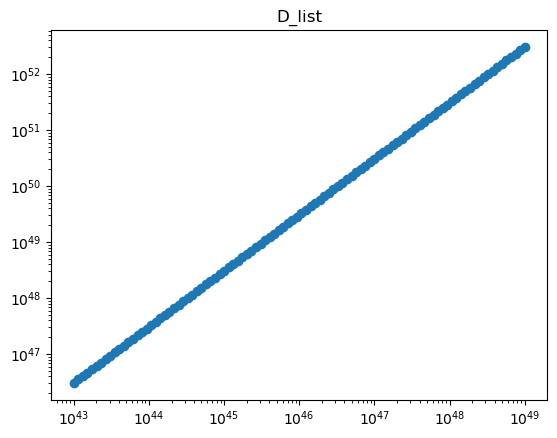

In [39]:
selected_model = 'AMPLE_Blazar'
#different models 'SLDDE_RG', 'AMPLE_Blazar', 'AMPLE_FSRQ', 'APLE_BLlac'
set_model_constants(selected_model)

blaz_ir_z1, blaz_ir_z2, blaz_ir_z3, blaz_ir_z4 = lum_den_calc()
blaz_ir_lx1, blaz_ir_lx2, blaz_ir_lx3, blaz_ir_lx4 = red_evo_calc()
blaz_em_j1, blaz_em_j2, blaz_em_j3, blaz_em_tot, blaz_avg_lx1, blaz_avg_lx2, blaz_avg_lx3, blaz_avg_tot = em_avg_calc(blaz_ir_lx1, blaz_ir_lx2, blaz_ir_lx3, blaz_ir_lx4)

blaz_n_tot =(blaz_ir_lx4)/cosmo1.differential_comoving_volume(Z_list).value/(4*np.pi)
popt1, popt2, popt3, popt_tot, popt_tot_em, popt_tot_n = return_fit_varaibles(blaz_avg_lx1, blaz_avg_lx2, blaz_avg_lx3, blaz_avg_tot, blaz_em_tot, blaz_n_tot,4)
#plt.figure()
#plt.scatter(Z_list,blaz_avg_tot)
#plt.plot(Z_list,broken_power_law(Z_list, *popt_tot))
#plt.title("average luminosity")
#plt.xscale('log')
#plt.yscale('log')
#plt.show()
D_list, popt_tot_D = D_list_calc(4)
blaz_d_phi = calc_phi()
#D_list_2, popt_tot_D_2 = D_fit_2()
#blaz_d_phi_2 = calc_phi_2()


SLDDE_RG
done 1
done 2
done 3
done 1
done 2
done 3
The model in question is:  SLDDE_RG
Fit parameters for array 1: a=2.00, b=-0.00, c=5.11, e=0.00
Fit parameters for array 2: a=2.00, b=-0.00, c=5.11, e=0.00
Fit parameters for array 3: a=2.00, b=-0.00, c=5.11, e=0.00
Fit parameters for avg_tot: a=9463015204437896530651424288778873800228864.00, b=-2.16, c=1.18, e=0.12
Fit parameters for em_tot: a=2370807247383113508481787417587865354240.00, b=-0.97, c=1.90, e=1.64
Fit parameters for n_tot: a=0.00, b=1.28, c=0.76, e=-0.60


C:\Users\henri\AppData\Local\Temp\ipykernel_15280\3311138847.py:24: RuntimeWarning: invalid value encountered in power
  return a*((z/c)**b+(z/c)**e)**(-1)


6.2415e+44 6.2415e+44
Fit parameters for D_list: a=3076.91, b=1.00


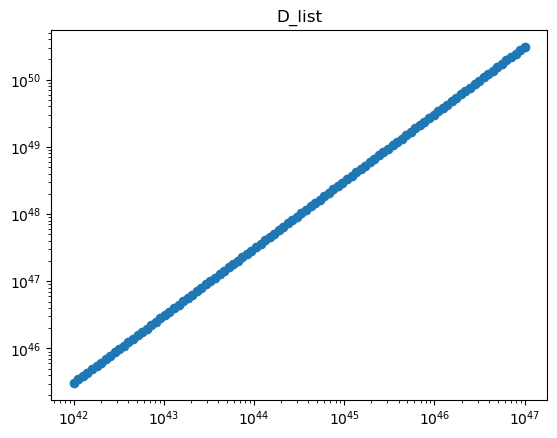

In [40]:
selected_model = 'SLDDE_RG'
#different models 'SLDDE_RG', 'AMPLE_Blazar', 'AMPLE_FSRQ', 'APLE_BLlac'
set_model_constants(selected_model)
rg_ir_z1, rg_ir_z2, rg_ir_z3, rg_ir_z4 = lum_den_calc()
rg_ir_lx1, rg_ir_lx2, rg_ir_lx3, rg_ir_lx4 = red_evo_calc()
rg_em_j1, rg_em_j2, rg_em_j3, rg_em_tot, rg_avg_lx1, rg_avg_lx2, rg_avg_lx3, rg_avg_tot = em_avg_calc(rg_ir_lx1, rg_ir_lx2, rg_ir_lx3, rg_ir_lx4)

rg_n_tot =(rg_ir_lx4)/cosmo1.differential_comoving_volume(Z_list).value/(4*np.pi)
popt1, popt2, popt3, popt_tot, popt_tot_em, popt_tot_n = return_fit_varaibles(rg_avg_lx1, rg_avg_lx2, rg_avg_lx3, rg_avg_tot, rg_em_tot, rg_n_tot,1.5)

D_list, popt_tot_D = D_list_calc(0.5)
rg_d_phi = calc_phi()
#D_list_2, popt_tot_D_2 = D_fit_2()
#rg_d_phi_2 = calc_phi_2()


In [41]:
selected_model = 'AMPLE_FSRQ'
#different models 'SLDDE_RG', 'AMPLE_Blazar', 'AMPLE_FSRQ', 'APLE_BLlac'
set_model_constants(selected_model)
fsrq_ir_z1, fsrq_ir_z2, fsrq_ir_z3, fsrq_ir_z4 = lum_den_calc()
fsrq_ir_lx1, fsrq_ir_lx2, fsrq_ir_lx3, fsrq_ir_lx4 = red_evo_calc()
fsrq_em_j1, fsrq_em_j2, fsrq_em_j3, fsrq_em_tot, fsrq_avg_lx1, fsrq_avg_lx2, fsrq_avg_lx3, fsrq_avg_tot = em_avg_calc(fsrq_ir_lx1, fsrq_ir_lx2, fsrq_ir_lx3, fsrq_ir_lx4)

fsrq_n_tot =(fsrq_ir_lx4)/cosmo1.differential_comoving_volume(Z_list).value/(4*np.pi)
popt1, popt2, popt3, popt_tot, popt_tot_em, popt_tot_n = return_fit_varaibles(fsrq_avg_lx1, fsrq_avg_lx2, fsrq_avg_lx3, fsrq_avg_tot, fsrq_em_tot, fsrq_n_tot,4)
D_list, popt_tot_D = D_list_calc(4)
fsrq_d_phi = calc_phi()

#D_list_2, popt_tot_D_2 = D_fit_2()
#fsrq_d_phi_2 = calc_phi_2()

AMPLE_FSRQ
done 1
done 2
done 3
done 1
done 2
done 3


APLE_BLlac
done 1
done 2
done 3
done 1
done 2
done 3
6.241500000000001e+46 6.241500000000001e+46
Fit parameters for D_list: a=3076.91, b=1.00


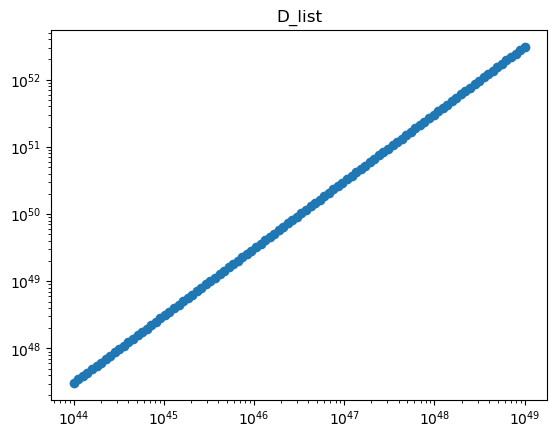

In [ ]:
selected_model = 'APLE_BLlac'
#different models 'SLDDE_RG', 'AMPLE_Blazar', 'AMPLE_FSRQ', 'APLE_BLlac, 'LDDE_AGN', 'APLE_Seyfert'
set_model_constants(selected_model)
bllac_ir_z1, bllac_ir_z2, bllac_ir_z3, bllac_ir_z4 = lum_den_calc()
bllac_ir_lx1, bllac_ir_lx2, bllac_ir_lx3, bllac_ir_lx4 = red_evo_calc()
bllac_em_j1, bllac_em_j2, bllac_em_j3, bllac_em_tot, bllac_avg_lx1, bllac_avg_lx2, bllac_avg_lx3, bllac_avg_tot = em_avg_calc(bllac_ir_lx1, bllac_ir_lx2, bllac_ir_lx3, bllac_ir_lx4)

bllac_n_tot =(bllac_ir_lx4)/cosmo1.differential_comoving_volume(Z_list).value/(4*np.pi)
#popt1, popt2, popt3, popt_tot, popt_tot_em, popt_tot_n = return_fit_varaibles(bllac_avg_lx1, bllac_avg_lx2, bllac_avg_lx3, bllac_avg_tot, bllac_em_tot, bllac_n_tot,0.5)
D_list, popt_tot_D = D_list_calc(3)
bllac_d_phi = calc_phi()

#D_list_2, popt_tot_D_2 = D_fit_2()
#bllac_d_phi_2 = calc_phi_2()

LDDE_AGN
done 1
done 2
done 3
done 1
done 2
done 3
6.2415e+44 6.2415e+44
Fit parameters for D_list: a=3076.91, b=1.00


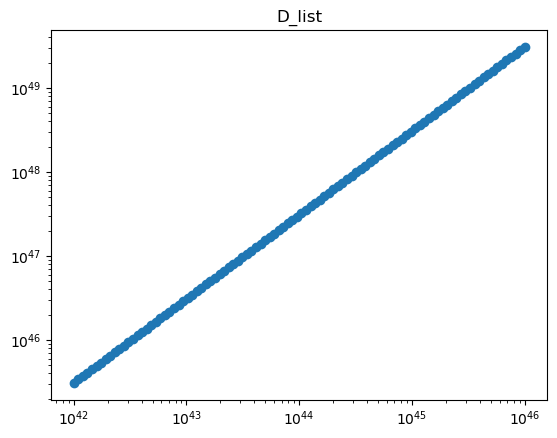

In [ ]:
selected_model = 'LDDE_AGN'
#different models 'SLDDE_RG', 'AMPLE_Blazar', 'AMPLE_FSRQ', 'APLE_BLlac, LDDE_AGN'
set_model_constants(selected_model)
AGN_ir_z1, AGN_ir_z2, AGN_ir_z3, AGN_ir_z4 = lum_den_calc()
AGN_ir_lx1, AGN_ir_lx2, AGN_ir_lx3, AGN_ir_lx4 = red_evo_calc()
AGN_em_j1, AGN_em_j2, AGN_em_j3, AGN_em_tot, AGN_avg_lx1, AGN_avg_lx2, AGN_avg_lx3, AGN_avg_tot = em_avg_calc(AGN_ir_lx1, AGN_ir_lx2, AGN_ir_lx3, AGN_ir_lx4)

AGN_n_tot =(AGN_ir_lx4)/cosmo1.differential_comoving_volume(Z_list).value/(4*np.pi)
#popt1, popt2, popt3, popt_tot, popt_tot_em, popt_tot_n = return_fit_varaibles(AGN_avg_lx1, AGN_avg_lx2, AGN_avg_lx3, AGN_avg_tot, AGN_em_tot, AGN_n_tot,4)
D_list, popt_tot_D = D_list_calc(3)
AGN_d_phi = calc_phi()
#D_list_2, popt_tot_D_2 = D_fit_2()
#AGN_d_phi_2 = calc_phi_2()


APLE_Seyfert
done 1
done 2
done 3
done 1
done 2
done 3
6.2415e+43 6.2415e+43
Fit parameters for D_list: a=3076.91, b=1.00


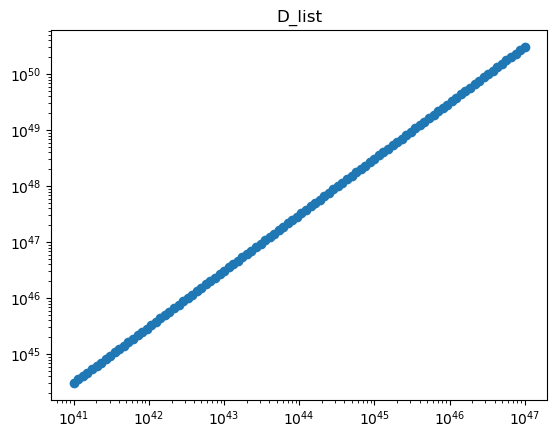

In [ ]:
selected_model = 'APLE_Seyfert'
#different models 'SLDDE_RG', 'AMPLE_Blazar', 'AMPLE_FSRQ', 'APLE_BLlac, 'LDDE_AGN', 'APLE_Seyfert'
set_model_constants(selected_model)
sey_ir_z1, sey_ir_z2, sey_ir_z3, sey_ir_z4 = lum_den_calc()
sey_ir_lx1, sey_ir_lx2, sey_ir_lx3, sey_ir_lx4 = red_evo_calc()
sey_em_j1, sey_em_j2, sey_em_j3, sey_em_tot, sey_avg_lx1, sey_avg_lx2, sey_avg_lx3, sey_avg_tot = em_avg_calc(sey_ir_lx1, sey_ir_lx2, sey_ir_lx3, sey_ir_lx4)

sey_n_tot =(sey_ir_lx4)/cosmo1.differential_comoving_volume(Z_list).value/(4*np.pi)
#popt1, popt2, popt3, popt_tot, popt_tot_em, popt_tot_n = return_fit_varaibles(sey_avg_lx1, sey_avg_lx2, sey_avg_lx3, sey_avg_tot, sey_em_tot, sey_n_tot,1)
D_list, popt_tot_D = D_list_calc(3)
sey_d_phi = calc_phi()
#D_list_2, popt_tot_D_2 = D_fit_2()
#sey_d_phi_2 = calc_phi_2()


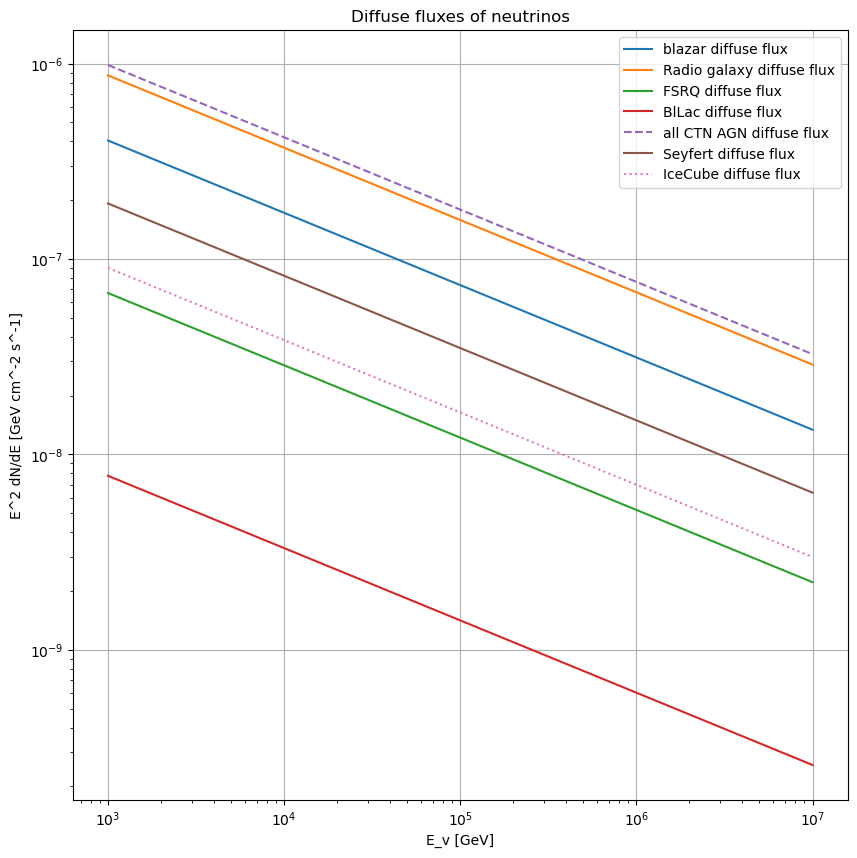

In [25]:
plt.figure(1,figsize=(10,10))


plt.plot(E_v_list,E_v_list**2*abs(blaz_d_phi),label = "blazar diffuse flux")
plt.plot(E_v_list,E_v_list**2*abs(rg_d_phi),label = "Radio galaxy diffuse flux")
plt.plot(E_v_list,E_v_list**2*abs(fsrq_d_phi),label = "FSRQ diffuse flux")
plt.plot(E_v_list,E_v_list**2*abs(bllac_d_phi),label = "BlLac diffuse flux")
plt.plot(E_v_list,E_v_list**2*abs(AGN_d_phi),label = "all CTN AGN diffuse flux",linestyle = 'dashed')
plt.plot(E_v_list,E_v_list**2*abs(sey_d_phi),label = "Seyfert diffuse flux")

plt.plot(E_v_list,E_v_list**2*ICECUBE(E_v_list, E_cut_ice,gamma,phi_cut),label = "IceCube diffuse flux", linestyle = 'dotted')
plt.ylabel("E^2 dN/dE [GeV cm^-2 s^-1]")
plt.yscale('log',base=10)
plt.xscale('log',base=10)
plt.xlabel("E_v [GeV]")
plt.title("Diffuse fluxes of neutrinos")
plt.legend()
plt.grid()
#plt.savefig("Rapport/new_plots/diffuse_fluxes_neutrino_no_cutoff.png")
plt.show()

[ 1.0001      1.09100808  1.18191616  1.27282424  1.36373232  1.4546404
  1.54554848  1.63645657  1.72736465  1.81827273  1.90918081  2.00008889
  2.09099697  2.18190505  2.27281313  2.36372121  2.45462929  2.54553737
  2.63644545  2.72735354  2.81826162  2.9091697   3.00007778  3.09098586
  3.18189394  3.27280202  3.3637101   3.45461818  3.54552626  3.63643434
  3.72734242  3.81825051  3.90915859  4.00006667  4.09097475  4.18188283
  4.27279091  4.36369899  4.45460707  4.54551515  4.63642323  4.72733131
  4.81823939  4.90914747  5.00005556  5.09096364  5.18187172  5.2727798
  5.36368788  5.45459596  5.54550404  5.63641212  5.7273202   5.81822828
  5.90913636  6.00004444  6.09095253  6.18186061  6.27276869  6.36367677
  6.45458485  6.54549293  6.63640101  6.72730909  6.81821717  6.90912525
  7.00003333  7.09094141  7.18184949  7.27275758  7.36366566  7.45457374
  7.54548182  7.6363899   7.72729798  7.81820606  7.90911414  8.00002222
  8.0909303   8.18183838  8.27274646  8.36365455  8.4

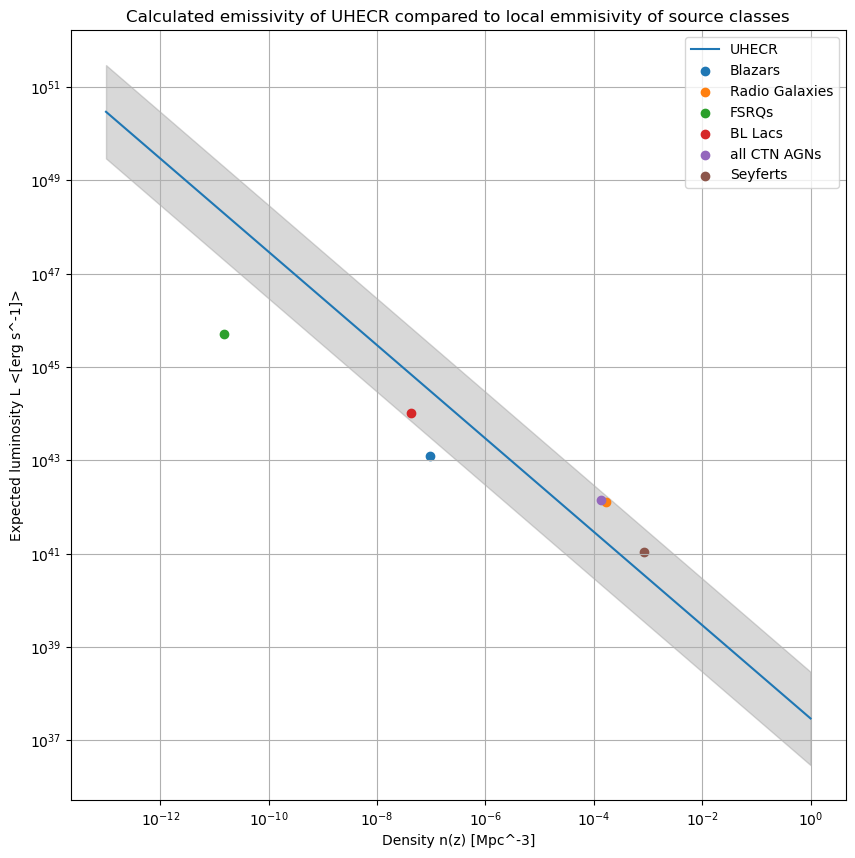

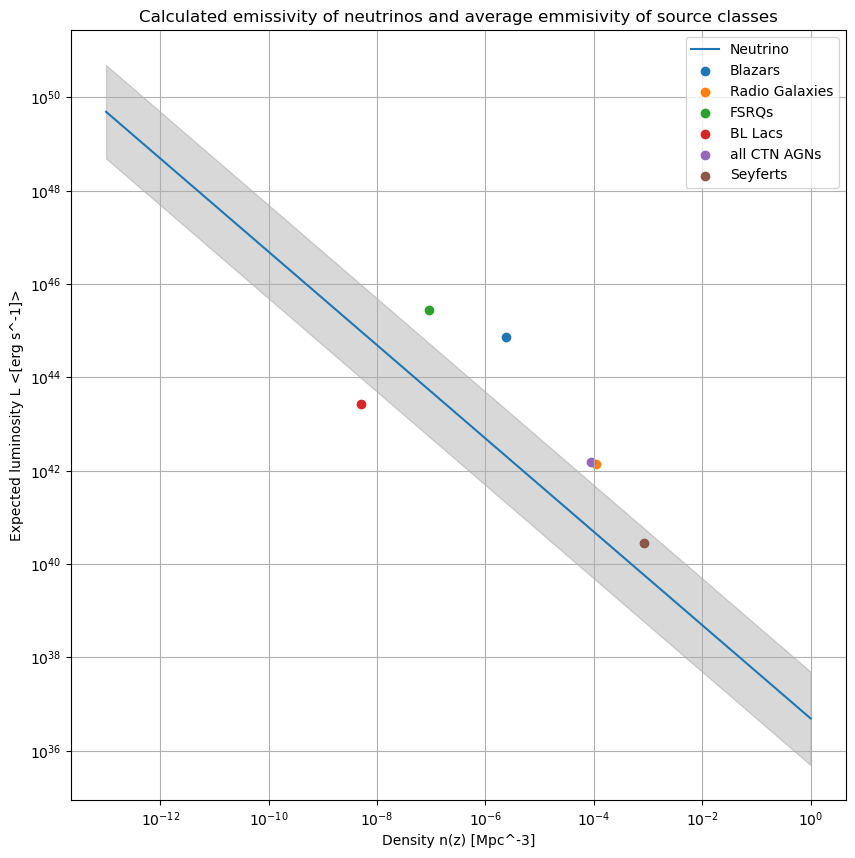

[0.00082788 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788
 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788
 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788
 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788
 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788
 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788
 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788
 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788
 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788
 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788
 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788
 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788
 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788
 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788
 0.00082788 0.00082788 0.00082788 0.00082788 0.00082788 0.0008

In [24]:
diffuse_flux_UHECR = 6*10**(17) #ev, do not know where this comes from. I dont get it. This turns into 3*10^44 ergs/s/Mpc^3 ??


L_neut =1.5466374965712159e+44#1.5466374965712159e+44*np.pi*4

# Define the value of n
n_values = np.logspace(-13, 0, 1000)

# Calculate the corresponding values of L # 9.268568906534487e+44
L_values = (9.268568906534487e+44) / n_values/(60*60*24*365)
L_values_2 = (L_neut)/ n_values/(60*60*24*365)

radius = 10

y_upper = L_values*radius
y_lower = L_values/radius

y_upper_2 = L_values_2*radius
y_lower_2 = L_values_2/radius

# Plot the line
plt.figure(1, figsize=(10,10))
plt.plot(n_values, L_values, label = "UHECR")
plt.fill_between(n_values, y_lower, y_upper, color='gray', alpha=0.3)
#plt.plot(n_values, L_values_2, label = "Neutrino")

# Add labels and title
plt.xlabel('Density n(z) [Mpc^-3]')
plt.yscale('log',base=10)
plt.xscale('log',base=10)
plt.ylabel('Expected luminosity L <[erg s^-1]>')
plt.scatter(blaz_n_tot[1], blaz_avg_tot[1], label='Blazars')
plt.scatter(rg_n_tot[1], rg_avg_tot[1], label='Radio Galaxies')
plt.scatter(fsrq_n_tot[1], fsrq_avg_tot[1], label='FSRQs')
plt.scatter(bllac_n_tot[1], bllac_avg_tot[1], label='BL Lacs')
plt.scatter(AGN_n_tot[1], AGN_avg_tot[1], label='all CTN AGNs')
plt.scatter(sey_n_tot[1], sey_avg_tot[1], label='Seyferts')
plt.title('Calculated emissivity of UHECR compared to local emmisivity of source classes')
plt.legend()
plt.grid()
plt.savefig('Rapport/new_plots/L_n_uhecr_calc.png')


plt.figure(2, figsize=(10,10))
#plt.plot(n_values, L_values, label = "UHECR")
redshift_arr = (1+Z_list)

print(redshift_arr)
plt.plot(n_values, L_values_2, label = "Neutrino")
plt.fill_between(n_values, y_lower_2, y_upper_2, color='gray', alpha=0.3)

# Add labels and title
plt.xlabel('Density n(z) [Mpc^-3]')
plt.yscale('log',base=10)
plt.xscale('log',base=10)
plt.ylabel('Expected luminosity L <[erg s^-1]>')
plt.scatter(sum(blaz_n_tot)/len(blaz_n_tot), sum(blaz_avg_tot/redshift_arr)/len(blaz_n_tot), label='Blazars')
plt.scatter(sum(rg_n_tot)/len(rg_n_tot), sum(rg_avg_tot/redshift_arr)/len(rg_n_tot), label='Radio Galaxies')
plt.scatter(sum(fsrq_n_tot)/len(fsrq_n_tot), sum(fsrq_avg_tot/redshift_arr)/len(fsrq_n_tot), label='FSRQs')
plt.scatter(sum(bllac_n_tot)/len(bllac_n_tot), sum(bllac_avg_tot/redshift_arr)/len(bllac_n_tot), label='BL Lacs')
plt.scatter(sum(AGN_n_tot)/len(AGN_n_tot), sum(AGN_avg_tot/redshift_arr)/len(AGN_n_tot), label='all CTN AGNs')
plt.scatter(sum(sey_n_tot)/len(sey_n_tot), sum(sey_avg_tot/redshift_arr)/len(sey_n_tot), label='Seyferts')



plt.title('Calculated emissivity of neutrinos and average emmisivity of source classes')
plt.legend()
plt.grid()



plt.savefig('Rapport/new_plots/L_n_neut_calc.png')
# Show the plot
plt.show()

#print(sey_n_tot)
#print((sey_ir_lx4)/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4))
#print(sey_ir_lx3/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4) + sey_ir_lx2/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4) + sey_ir_lx1/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4)+ sey_ir_lx2/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4)) 

AMPLE_Blazar


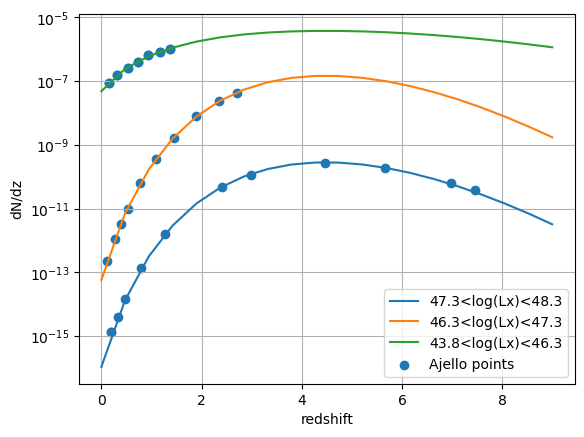

In [ ]:


data = np.loadtxt('plot-data (1)_blazar_ajello.csv', delimiter=',', skiprows=1)
data = np.loadtxt('plot-data (2).csv', delimiter=',', skiprows=1)
#data2 = np.loadtxt('plot-data (1)new2.csv', delimiter=',', skiprows=1)


selected_model = 'AMPLE_Blazar'
#different models 'SLDDE_RG', 'AMPLE_Blazar', 'AMPLE_FSRQ', 'APLE_BLlac'
set_model_constants(selected_model)


integral_results_lx= prefrom_int(lx_func, Z_list,10**47.3, 10**48.3)

integral_results_lx__2= prefrom_int(lx_func, Z_list,10**46.3, 10**47.3)
integral_results_lx__3= prefrom_int(lx_func, Z_list,10**43.8, 10**46.3)
plt.figure(2)
plt.plot(Z_list,(integral_results_lx)/cosmo1.differential_comoving_volume(Z_list)/4/np.pi,label = f"{47.3}<log(Lx)<{48.3}")
plt.plot(Z_list,(integral_results_lx__2)/cosmo1.differential_comoving_volume(Z_list)/4/np.pi,label = f"{46.3}<log(Lx)<{ 47.3}")
plt.plot(Z_list,(integral_results_lx__3)/cosmo1.differential_comoving_volume(Z_list)/4/np.pi,label = f"{43.8}<log(Lx)<{ 46.3}")
plt.scatter(data[:,0],data[:,1],label = "Ajello points")
#plt.scatter(data2[:,0],data2[:,1])
plt.plot()
plt.ylabel("dN/dz")
plt.xlabel("redshift")
plt.yscale('log',base=10)
#plt.xscale('log',base=10)
#plt.ylim(10**(-1),10**(9))
#plt.xlim(10**(-2),10**(2))
plt.legend()
plt.grid()
plt.savefig("new_plots/Blazar_test_fit.png")
plt.show()

AMPLE_Blazar
SLDDE_RG
AMPLE_FSRQ
APLE_BLlac
LDDE_AGN
APLE_Seyfert


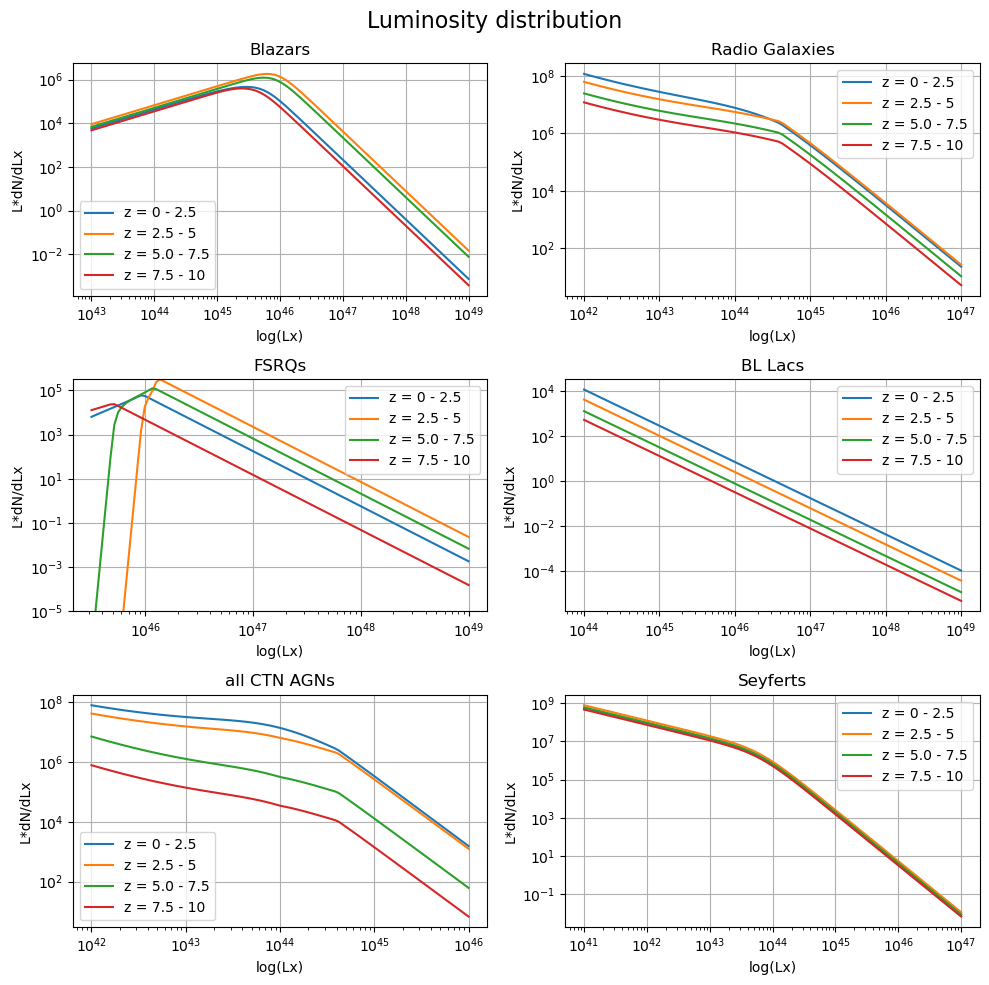

AMPLE_Blazar
SLDDE_RG
AMPLE_FSRQ
APLE_BLlac
LDDE_AGN
APLE_Seyfert


<Figure size 1000x1000 with 0 Axes>

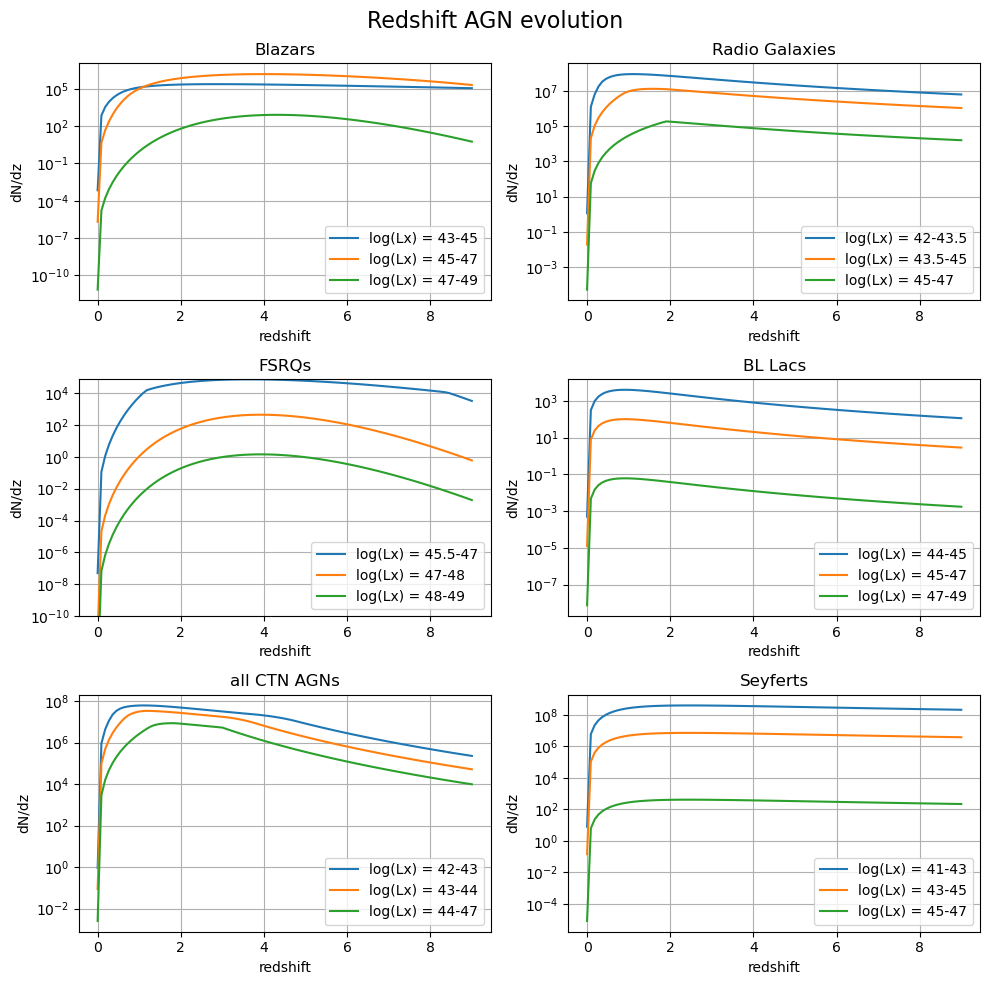

AMPLE_Blazar
SLDDE_RG
AMPLE_FSRQ
APLE_BLlac
LDDE_AGN
APLE_Seyfert


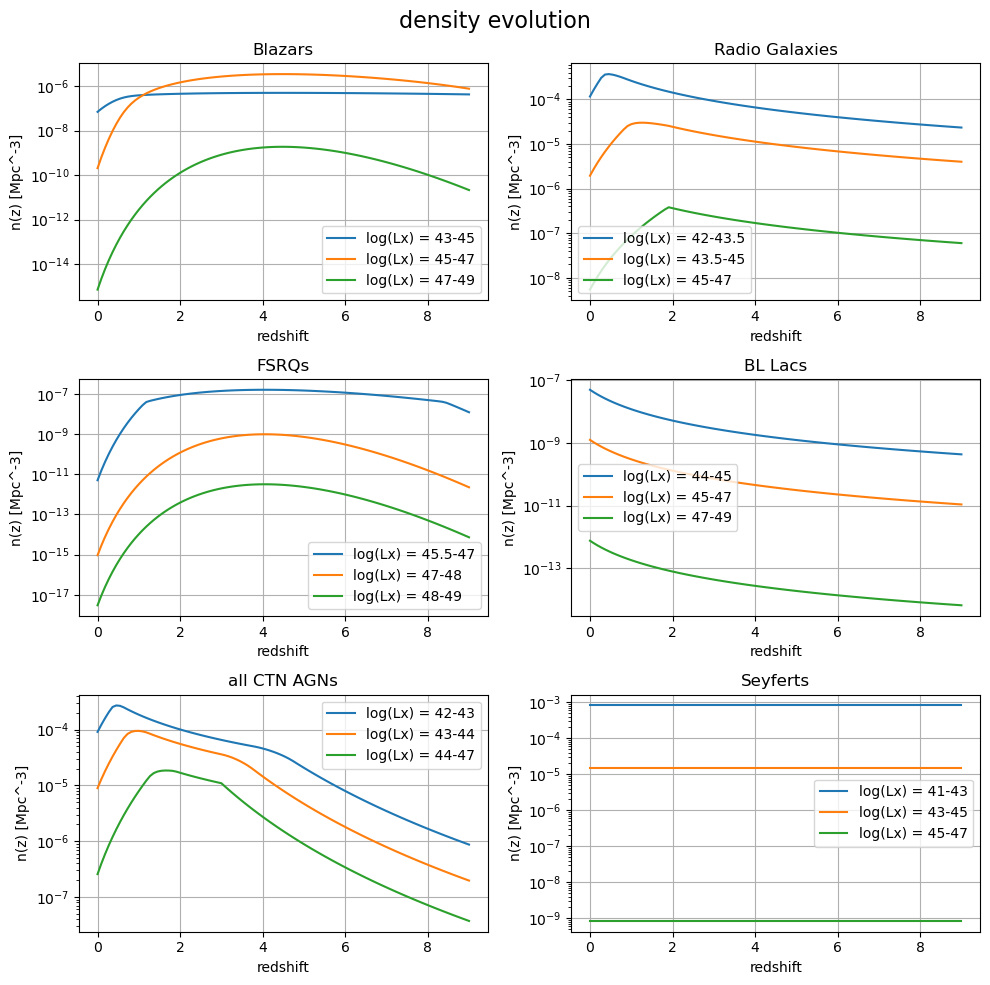

[7.04090202e-08 9.65752114e-08 1.28156774e-07 1.65506057e-07
 2.08906623e-07 2.58569235e-07 3.14629576e-07 3.77147532e-07
 4.46107885e-07 5.21422225e-07 6.02931938e-07 6.90412085e-07
 7.83576036e-07 8.82080692e-07 9.85532162e-07 1.09349176e-06
 1.20548222e-06 1.32099400e-06 1.43949154e-06 1.56041955e-06]
[5.15472468e-08 4.30932745e-08 3.65664274e-08 3.14535320e-08
 2.74325165e-08 2.43206897e-08 2.20529816e-08 2.06794538e-08
 2.03759003e-08 2.14632094e-08 2.44317029e-08 2.99666099e-08
 3.89654121e-08 5.02810043e-08 5.50508203e-08 5.93875592e-08
 6.39784911e-08 6.87859971e-08 7.37697240e-08 7.88899790e-08]


In [246]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.flatten()  
selected_model = 'AMPLE_Blazar'

set_model_constants(selected_model)
axs[0].plot(L_x, L_x* blaz_ir_z1, label='z = 0 - 2.5')
axs[0].plot(L_x, L_x* blaz_ir_z2, label='z = 2.5 - 5')
axs[0].plot(L_x, L_x* blaz_ir_z3, label='z = 5.0 - 7.5')
axs[0].plot(L_x,L_x*  blaz_ir_z4, label='z = 7.5 - 10')
axs[0].set_title('Blazars')
axs[0].set_xlabel('log(Lx)')
axs[0].set_ylabel('L*dN/dLx')
axs[0].set_yscale('log',base=10)
axs[0].set_xscale('log',base=10)
axs[0].legend()
axs[0].grid()


selected_model = 'SLDDE_RG'

set_model_constants(selected_model)
axs[1].plot(L_x, L_x* rg_ir_z1, label='z = 0 - 2.5')
axs[1].plot(L_x, L_x* rg_ir_z2, label='z = 2.5 - 5')
axs[1].plot(L_x, L_x* rg_ir_z3, label='z = 5.0 - 7.5')
axs[1].plot(L_x, L_x* rg_ir_z4, label='z = 7.5 - 10')
axs[1].set_title('Radio Galaxies')
axs[1].set_xlabel('log(Lx)')
axs[1].set_ylabel('L*dN/dLx')
axs[1].set_yscale('log',base=10)
axs[1].set_xscale('log',base=10)
axs[1].legend()
axs[1].grid()

selected_model = 'AMPLE_FSRQ'

set_model_constants(selected_model)

axs[2].plot(L_x,L_x*  fsrq_ir_z1, label='z = 0 - 2.5')
axs[2].plot(L_x, L_x* fsrq_ir_z2, label='z = 2.5 - 5')
axs[2].plot(L_x, L_x* fsrq_ir_z3, label='z = 5.0 - 7.5')
axs[2].plot(L_x, L_x* fsrq_ir_z4, label='z = 7.5 - 10')
axs[2].set_title('FSRQs')
axs[2].set_ylim(10**(-5))
axs[2].set_xlabel('log(Lx)')
axs[2].set_ylabel('L*dN/dLx')
axs[2].set_yscale('log',base=10)
axs[2].set_xscale('log',base=10)
axs[2].legend()
axs[2].grid()

selected_model = 'APLE_BLlac'

set_model_constants(selected_model)
axs[3].plot(L_x, L_x* bllac_ir_z1, label='z = 0 - 2.5')
axs[3].plot(L_x, L_x* bllac_ir_z2, label='z = 2.5 - 5')
axs[3].plot(L_x, L_x* bllac_ir_z3, label='z = 5.0 - 7.5')
axs[3].plot(L_x, L_x* bllac_ir_z4, label='z = 7.5 - 10')
axs[3].set_title('BL Lacs')
axs[3].set_xlabel('log(Lx)')
axs[3].set_ylabel('L*dN/dLx')
axs[3].set_yscale('log',base=10)
axs[3].set_xscale('log',base=10)
axs[3].legend()
axs[3].grid()

selected_model = 'LDDE_AGN'

set_model_constants(selected_model)
axs[4].plot(L_x, L_x* AGN_ir_z1, label='z = 0 - 2.5')
axs[4].plot(L_x, L_x* AGN_ir_z2, label='z = 2.5 - 5')
axs[4].plot(L_x, L_x* AGN_ir_z3, label='z = 5.0 - 7.5')
axs[4].plot(L_x, L_x* AGN_ir_z4, label='z = 7.5 - 10')
axs[4].set_title('all CTN AGNs')
axs[4].set_xlabel('log(Lx)')
axs[4].set_ylabel('L*dN/dLx')
axs[4].set_yscale('log',base=10)
axs[4].set_xscale('log',base=10)
axs[4].legend()
axs[4].grid()

selected_model = 'APLE_Seyfert'

set_model_constants(selected_model)
axs[5].plot(L_x, L_x* sey_ir_z1, label='z = 0 - 2.5')
axs[5].plot(L_x, L_x* sey_ir_z2, label='z = 2.5 - 5')
axs[5].plot(L_x, L_x* sey_ir_z3, label='z = 5.0 - 7.5')
axs[5].plot(L_x, L_x* sey_ir_z4, label='z = 7.5 - 10')
axs[5].set_title('Seyferts')
axs[5].set_xlabel('log(Lx)')
axs[5].set_ylabel('L*dN/dLx')
axs[5].set_yscale('log',base=10)
axs[5].set_xscale('log',base=10)
axs[5].legend()
axs[5].grid()






fig.suptitle('Luminosity distribution', fontsize=16)


plt.tight_layout()
plt.savefig('Rapport/new_plots/Luminosity density.png')

plt.show()


plt.figure(2,figsize=(10,10))


fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.flatten()
selected_model = 'AMPLE_Blazar'

set_model_constants(selected_model)
axs[0].plot(Z_list, blaz_ir_lx1, label=f'log(Lx) = {a1}-{a2}')
axs[0].plot(Z_list, blaz_ir_lx2, label=f'log(Lx) = {a3}-{a4}')
axs[0].plot(Z_list, blaz_ir_lx3, label=f'log(Lx) = {a5}-{a6}')
#axs[0].plot(Z_list, blaz_ir_lx4, label=f'log(Lx) = {a7}-{a8}')

axs[0].set_title('Blazars')
axs[0].set_xlabel('redshift')
axs[0].set_ylabel('dN/dz')
axs[0].set_yscale('log',base=10)
axs[0].legend()
axs[0].grid()


selected_model = 'SLDDE_RG'

set_model_constants(selected_model)
axs[1].plot(Z_list, rg_ir_lx1, label=f'log(Lx) = {a1}-{a2}')
axs[1].plot(Z_list, rg_ir_lx2, label=f'log(Lx) = {a3}-{a4}')
axs[1].plot(Z_list, rg_ir_lx3, label=f'log(Lx) = {a5}-{a6}')
#axs[1].plot(Z_list, rg_ir_lx4, label=f'log(Lx) = {a7}-{a8}')

axs[1].set_title('Radio Galaxies')
axs[1].set_xlabel('redshift')
axs[1].set_ylabel('dN/dz')
axs[1].set_yscale('log',base=10)
axs[1].legend()
axs[1].grid()


selected_model = 'AMPLE_FSRQ'

set_model_constants(selected_model)
axs[2].plot(Z_list, fsrq_ir_lx1, label=f'log(Lx) = {a1}-{a2}')
axs[2].plot(Z_list, fsrq_ir_lx2, label=f'log(Lx) = {a3}-{a4}')
axs[2].plot(Z_list, fsrq_ir_lx3, label=f'log(Lx) = {a5}-{a6}')
#axs[2].plot(Z_list, fsrq_ir_lx4, label=f'log(Lx) = {a7}-{a8}')
axs[2].set_ylim(10**(-10))
axs[2].set_title('FSRQs')
axs[2].set_xlabel('redshift')
axs[2].set_ylabel('dN/dz')
axs[2].set_yscale('log',base=10)
axs[2].legend()
axs[2].grid()

selected_model = 'APLE_BLlac'

set_model_constants(selected_model)
axs[3].plot(Z_list, bllac_ir_lx1, label=f'log(Lx) = {a1}-{a2}')
axs[3].plot(Z_list, bllac_ir_lx2, label=f'log(Lx) = {a3}-{a4}')
axs[3].plot(Z_list, bllac_ir_lx3, label=f'log(Lx) = {a5}-{a6}')
#axs[3].plot(Z_list, bllac_ir_lx4, label=f'log(Lx) = {a7}-{a8}')

axs[3].set_title('BL Lacs')
axs[3].set_xlabel('redshift')
axs[3].set_ylabel('dN/dz')
axs[3].set_yscale('log',base=10)
axs[3].legend()
axs[3].grid()


selected_model = 'LDDE_AGN'

set_model_constants(selected_model)
axs[4].plot(Z_list, AGN_ir_lx1, label=f'log(Lx) = {a1}-{a2}')
axs[4].plot(Z_list, AGN_ir_lx2, label=f'log(Lx) = {a3}-{a4}')
axs[4].plot(Z_list, AGN_ir_lx3, label=f'log(Lx) = {a5}-{a6}')
#axs[4].plot(Z_list, AGN_ir_lx4, label=f'log(Lx) = {a7}-{a8}')

axs[4].set_title('all CTN AGNs')
axs[4].set_xlabel('redshift')
axs[4].set_ylabel('dN/dz')
axs[4].set_yscale('log',base=10)
axs[4].legend()
axs[4].grid()

selected_model = 'APLE_Seyfert'

set_model_constants(selected_model)
axs[5].plot(Z_list, sey_ir_lx1, label=f'log(Lx) = {a1}-{a2}')
axs[5].plot(Z_list, sey_ir_lx2, label=f'log(Lx) = {a3}-{a4}')
axs[5].plot(Z_list, sey_ir_lx3, label=f'log(Lx) = {a5}-{a6}')
#axs[5].plot(Z_list, sey_ir_lx4, label=f'log(Lx) = {a7}-{a8}')

axs[5].set_title('Seyferts')
axs[5].set_xlabel('redshift')
axs[5].set_ylabel('dN/dz')
axs[5].set_yscale('log',base=10)
axs[5].legend()
axs[5].grid()


fig.suptitle('Redshift AGN evolution', fontsize=16)


plt.tight_layout()
plt.savefig('Rapport/new_plots/Redshift AGN evolution.png')

plt.show()







fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.flatten()
selected_model = 'AMPLE_Blazar'

set_model_constants(selected_model)
axs[0].plot(Z_list, blaz_ir_lx1/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a1}-{a2}')
axs[0].plot(Z_list, blaz_ir_lx2/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a3}-{a4}')
axs[0].plot(Z_list, blaz_ir_lx3/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a5}-{a6}')

#axs[0].plot(Z_list, blaz_ir_lx4/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a1}-{a6}')
#axs[0].plot(Z_list, blaz_ir_lx3/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4)+blaz_ir_lx2/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4)+blaz_ir_lx1/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a1}-{a6} again')

axs[0].set_title('Blazars')
axs[0].set_xlabel('redshift')
axs[0].set_ylabel('n(z) [Mpc^-3]')
axs[0].set_yscale('log',base=10)
axs[0].legend()
axs[0].grid()


selected_model = 'SLDDE_RG'

set_model_constants(selected_model)
axs[1].plot(Z_list, rg_ir_lx1/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a1}-{a2}')
axs[1].plot(Z_list, rg_ir_lx2/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a3}-{a4}')
axs[1].plot(Z_list, rg_ir_lx3/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a5}-{a6}')
#axs[1].plot(Z_list, rg_ir_lx4/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a1}-{a6}')
#axs[1].plot(Z_list, rg_ir_lx3/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4)+rg_ir_lx2/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4)+rg_ir_lx1/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a1}-{a6} again')

axs[1].set_title('Radio Galaxies')
axs[1].set_xlabel('redshift')
axs[1].set_ylabel('n(z) [Mpc^-3]')
axs[1].set_yscale('log',base=10)
axs[1].legend()
axs[1].grid()


selected_model = 'AMPLE_FSRQ'

set_model_constants(selected_model)
axs[2].plot(Z_list, fsrq_ir_lx1/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a1}-{a2}')
axs[2].plot(Z_list, fsrq_ir_lx2/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a3}-{a4}')
axs[2].plot(Z_list, fsrq_ir_lx3/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a5}-{a6}')
#axs[2].plot(Z_list, fsrq_ir_lx4/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a1}-{a6}')
#axs[2].plot(Z_list, fsrq_ir_lx3/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4)+fsrq_ir_lx2/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4)+fsrq_ir_lx1/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a1}-{a6} again')

axs[2].set_title('FSRQs')
axs[2].set_xlabel('redshift')
axs[2].set_ylabel('n(z) [Mpc^-3]')
axs[2].set_yscale('log',base=10)
axs[2].legend()
axs[2].grid()

selected_model = 'APLE_BLlac'

set_model_constants(selected_model)
axs[3].plot(Z_list, bllac_ir_lx1/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a1}-{a2}')
axs[3].plot(Z_list, bllac_ir_lx2/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a3}-{a4}')
axs[3].plot(Z_list, bllac_ir_lx3/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a5}-{a6}')
#axs[3].plot(Z_list, bllac_ir_lx4/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a1}-{a6}')
#axs[3].plot(Z_list, bllac_ir_lx3/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4)+bllac_ir_lx2/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4)+bllac_ir_lx1/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a1}-{a6} again')


axs[3].set_title('BL Lacs')
axs[3].set_xlabel('redshift')
axs[3].set_ylabel('n(z) [Mpc^-3]')
axs[3].set_yscale('log',base=10)
axs[3].legend()
axs[3].grid()


selected_model = 'LDDE_AGN'

set_model_constants(selected_model)
axs[4].plot(Z_list, AGN_ir_lx1/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a1}-{a2}')
axs[4].plot(Z_list, AGN_ir_lx2/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a3}-{a4}')
axs[4].plot(Z_list, AGN_ir_lx3/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a5}-{a6}')
#axs[4].plot(Z_list, AGN_ir_lx4/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a1}-{a6}')
#axs[4].plot(Z_list, AGN_ir_lx3/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4)+AGN_ir_lx2/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4)+AGN_ir_lx1/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a1}-{a6} again')


axs[4].set_title('all CTN AGNs')
axs[4].set_xlabel('redshift')
axs[4].set_ylabel('n(z) [Mpc^-3]')
axs[4].set_yscale('log',base=10)
axs[4].legend()
axs[4].grid()

selected_model = 'APLE_Seyfert'

set_model_constants(selected_model)
axs[5].plot(Z_list, sey_ir_lx1/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a1}-{a2}')
axs[5].plot(Z_list, sey_ir_lx2/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a3}-{a4}')
axs[5].plot(Z_list, sey_ir_lx3/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a5}-{a6}')
#axs[5].plot(Z_list, sey_ir_lx4/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a1}-{a6}')
#axs[5].plot(Z_list, sey_ir_lx3/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4)+sey_ir_lx2/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4)+sey_ir_lx1/cosmo1.differential_comoving_volume(Z_list)/(np.pi*4), label=f'log(Lx) = {a1}-{a6} again')

axs[5].set_title('Seyferts')
axs[5].set_xlabel('redshift')
axs[5].set_ylabel('n(z) [Mpc^-3]')
axs[5].set_yscale('log',base=10)
axs[5].legend()
axs[5].grid()


fig.suptitle('density evolution', fontsize=16)


plt.tight_layout()
plt.savefig('Rapport/new_plots/Redshift density evolution.png')

plt.show()

print(blaz_n_tot[0:20])
print(bllac_n_tot[0:20]+fsrq_n_tot[0:20] )








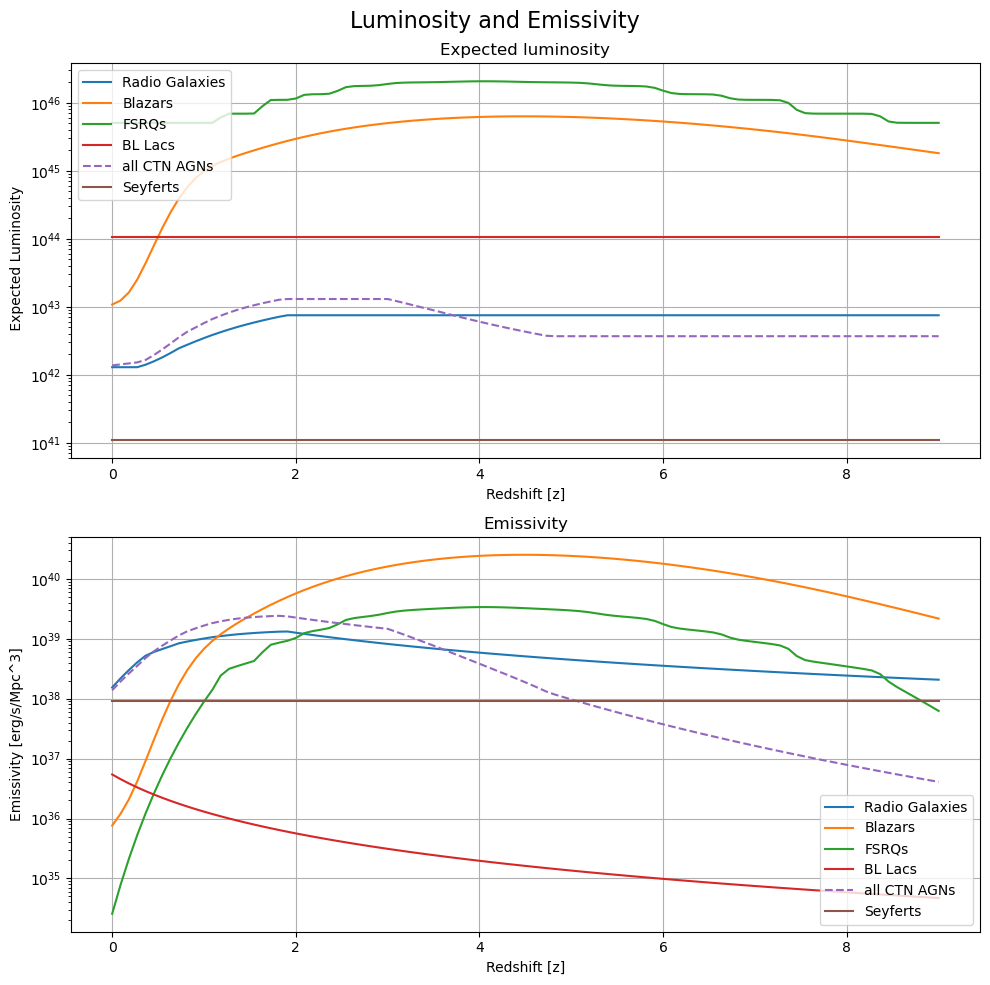

[9.04318004e+37 9.04318004e+37 9.04318004e+37 9.04318004e+37
 9.04318004e+37 9.04318004e+37 9.04318004e+37 9.04318004e+37
 9.04318004e+37 9.04318004e+37 9.04318004e+37 9.04318004e+37
 9.04318004e+37 9.04318004e+37 9.04318004e+37 9.04318004e+37
 9.04318004e+37 9.04318004e+37 9.04318004e+37 9.04318004e+37
 9.04318004e+37 9.04318004e+37 9.04318004e+37 9.04318004e+37
 9.04318004e+37 9.04318004e+37 9.04318004e+37 9.04318004e+37
 9.04318004e+37 9.04318004e+37 9.04318004e+37 9.04318004e+37
 9.04318004e+37 9.04318004e+37 9.04318004e+37 9.04318004e+37
 9.04318004e+37 9.04318004e+37 9.04318004e+37 9.04318004e+37
 9.04318004e+37 9.04318004e+37 9.04318004e+37 9.04318004e+37
 9.04318004e+37 9.04318004e+37 9.04318004e+37 9.04318004e+37
 9.04318004e+37 9.04318004e+37 9.04318004e+37 9.04318004e+37
 9.04318004e+37 9.04318004e+37 9.04318004e+37 9.04318004e+37
 9.04318004e+37 9.04318004e+37 9.04318004e+37 9.04318004e+37
 9.04318004e+37 9.04318004e+37 9.04318004e+37 9.04318004e+37
 9.04318004e+37 9.043180

In [247]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs = axs.flatten()
axs[0].plot(Z_list, rg_avg_tot, label=f'Radio Galaxies')
axs[0].plot(Z_list, blaz_avg_tot, label=f'Blazars')
axs[0].plot(Z_list, fsrq_avg_tot, label=f'FSRQs')
axs[0].plot(Z_list, bllac_avg_tot, label=f'BL Lacs')
axs[0].plot(Z_list, AGN_avg_tot, label=f'all CTN AGNs', linestyle = 'dashed')
axs[0].plot(Z_list,sey_avg_tot, label=f'Seyferts')
axs[0].set_title('Expected luminosity')
axs[0].set_xlabel('Redshift [z]')
axs[0].set_ylabel(' Expected Luminosity')
axs[0].set_yscale('log',base=10)
axs[0].legend()
axs[0].grid()

axs[1].plot(Z_list, rg_em_tot, label=f'Radio Galaxies')
#axs[1].plot(Z_list, rg_avg_tot*rg_n_tot, label=f'rgs 2')
axs[1].plot(Z_list, blaz_em_tot, label=f'Blazars')
#axs[1].plot(Z_list, blaz_avg_tot*blaz_n_tot, label=f'blazars 2')
axs[1].plot(Z_list, fsrq_em_tot, label=f'FSRQs')
#axs[1].plot(Z_list,fsrq_avg_tot*fsrq_n_tot , label=f'fsrqs 2')
axs[1].plot(Z_list, bllac_em_tot, label=f'BL Lacs')
#axs[1].plot(Z_list,bllac_avg_tot*bllac_n_tot , label=f'bllacs 2')
axs[1].plot(Z_list, AGN_em_tot, label=f'all CTN AGNs', linestyle='dashed')
#axs[1].plot(Z_list,AGN_avg_tot*AGN_n_tot , label=f'AGNs 2')
axs[1].plot(Z_list,sey_em_tot, label=f'Seyferts')
#axs[1].plot(Z_list,sey_avg_tot*sey_n_tot , label=f'Seyferts 2')
#axs[1].plot(Z_list,fsrq_em_tot+bllac_em_tot, label=f'Bllacs + FSRQs')
axs[1].set_title('Emissivity')
axs[1].set_xlabel('Redshift [z]')
axs[1].set_ylabel('Emissivity [erg/s/Mpc^3]')
axs[1].set_yscale('log',base=10)
axs[1].legend()
axs[1].grid()

fig.suptitle('Luminosity and Emissivity', fontsize=16)
plt.tight_layout()
plt.savefig('Rapport/new_plots/Luminosity and Emissivity.png')

plt.show()


#print(sey_n_tot)
#print(sey_em_tot)
#print(sey_avg_tot)
print(sey_avg_tot*sey_n_tot)
print()






[1.36664563e-08 6.67080119e-22 3.23243995e-23 5.49915885e-24
 1.56479087e-24 5.90262159e-25 2.66121418e-25 1.35694744e-25
 7.57126972e-26 4.52538901e-26]
[1.34501809e-08 6.56523390e-22 3.18128569e-23 5.41213314e-24
 1.54002762e-24 5.80921096e-25 2.61909973e-25 1.33547337e-25
 7.45145227e-26 4.45377347e-26]
